# Visualize TorNet Classifications

This notebook loads a pretrained keras model and tests it on TorNet samples

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # set to 'tensorflow', 'torch' or 'jax' (installs required)

In [2]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [3]:
from tornet.data.keras.loader import KerasDataLoader

## Run model on tornado samples

In [ ]:
# SET DATA ROOT HERE
data_root= 'C:/Users/mjhig/tornet_2013'

catalog_path = os.path.join(data_root,'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at '+data_root)
        
catalog = pd.read_csv(catalog_path,parse_dates=['start_time','end_time'])


In [5]:
catalog = catalog[catalog.start_time.dt.year.isin([2013, 2014])]
catalog = catalog[catalog['ef_number'] >= 0]

ds_test = KerasDataLoader(data_root=data_root,
                         data_type='train',
                         random_state=1234,
                         catalog=catalog,
                         batch_size = 1, 
                         workers = 4,
                         use_multiprocessing = True)

  0%|          | 0/1505 [00:00<?, ?it/s]

tf.Tensor(0.9656906, shape=(), dtype=float32)


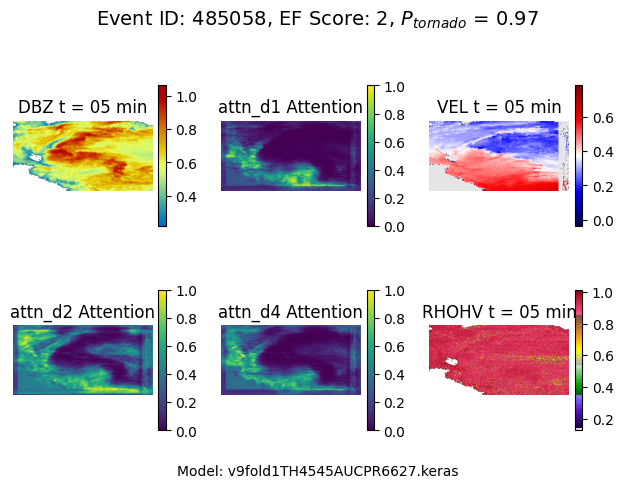

  0%|          | 1/1505 [00:03<1:36:27,  3.85s/it]

tf.Tensor(0.010039442, shape=(), dtype=float32)


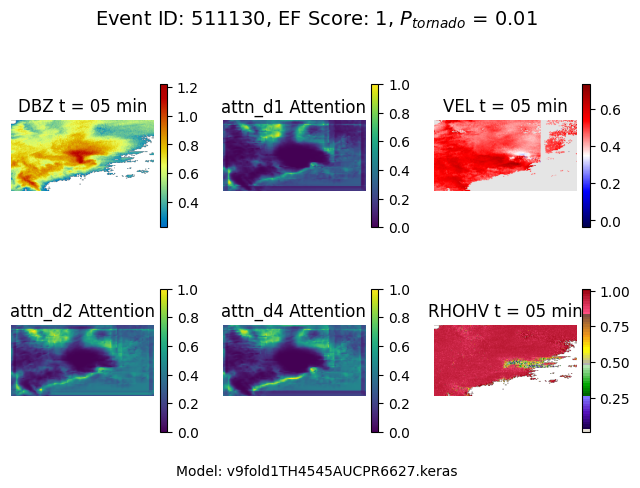

  0%|          | 2/1505 [00:05<1:09:49,  2.79s/it]

tf.Tensor(0.7467384, shape=(), dtype=float32)


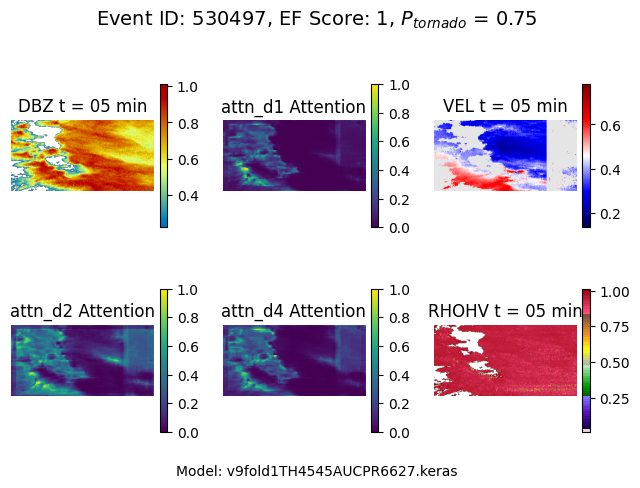

  0%|          | 3/1505 [00:08<1:06:55,  2.67s/it]

tf.Tensor(0.9347103, shape=(), dtype=float32)


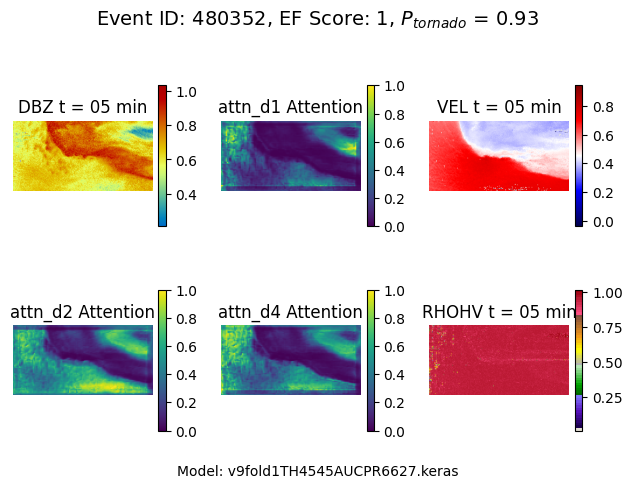

  0%|          | 4/1505 [00:10<1:00:38,  2.42s/it]

tf.Tensor(0.96763533, shape=(), dtype=float32)


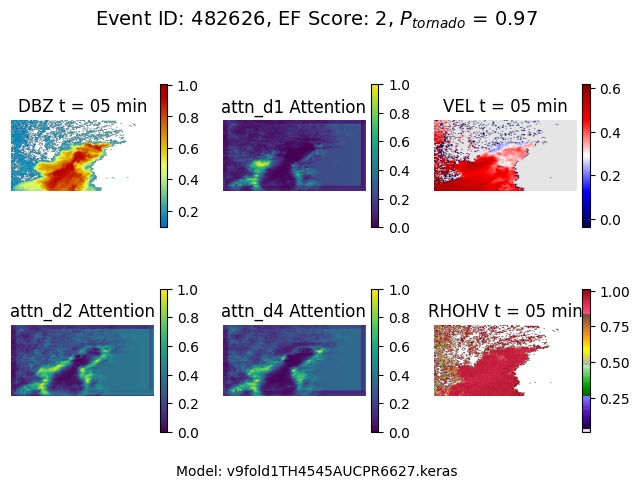

  0%|          | 5/1505 [00:12<56:38,  2.27s/it]  

tf.Tensor(0.9820523, shape=(), dtype=float32)


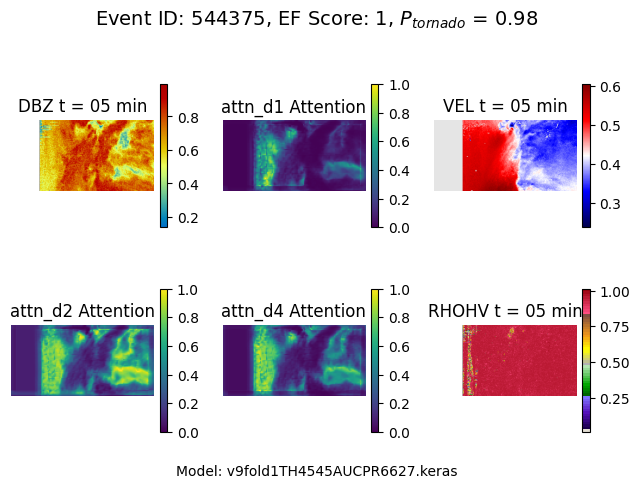

  0%|          | 6/1505 [00:14<55:08,  2.21s/it]

tf.Tensor(0.5033136, shape=(), dtype=float32)


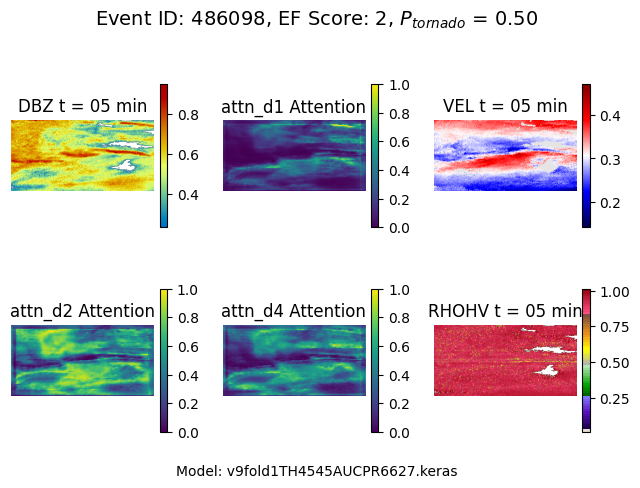

  0%|          | 7/1505 [00:16<53:40,  2.15s/it]

tf.Tensor(0.010479449, shape=(), dtype=float32)


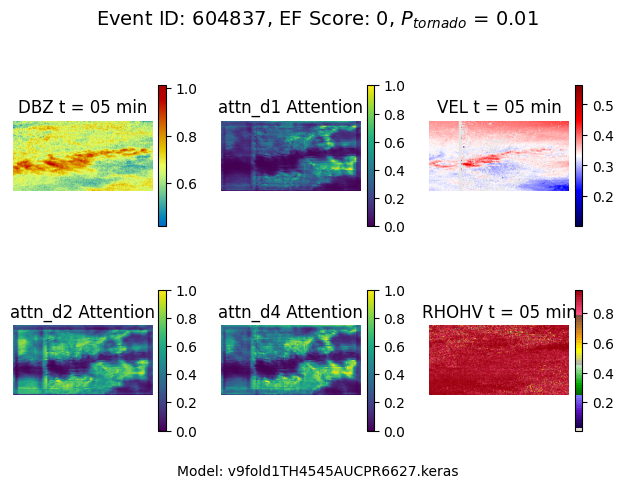

  1%|          | 8/1505 [00:18<54:08,  2.17s/it]

tf.Tensor(0.9846637, shape=(), dtype=float32)


  1%|          | 8/1505 [00:19<1:00:22,  2.42s/it]


KeyboardInterrupt: 

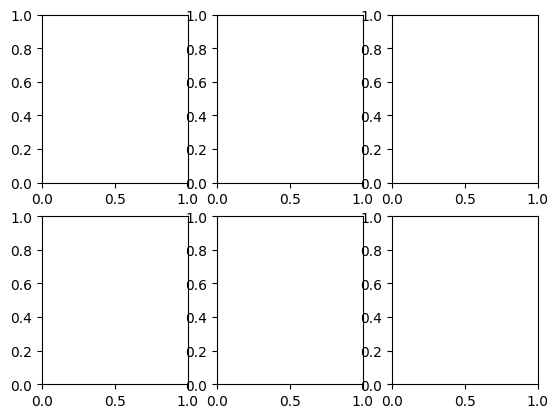

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
from tornet.data.constants import CHANNEL_MIN_MAX
from tornet.display.display import get_cmap
from tqdm import tqdm

# Suppress warnings and TensorFlow logging
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

@keras.utils.register_keras_serializable()
class FillNaNs(keras.layers.Layer):
    def __init__(self, fill_val, **kwargs):
        super().__init__(**kwargs)
        self.fill_val = tf.convert_to_tensor(fill_val, dtype=tf.float32)

    @tf.function(jit_compile=True)
    def call(self, x):
        return tf.where(tf.math.is_nan(x), self.fill_val, x)

    def get_config(self):
        return {**super().get_config(), "fill_val": self.fill_val.numpy().item()}
    
@keras.utils.register_keras_serializable()
class FastNormalize(keras.layers.Layer):
    def __init__(self, mean, std, **kwargs):
        super().__init__(**kwargs)
        self.mean = tf.convert_to_tensor(mean, dtype=tf.float32)
        self.std = tf.convert_to_tensor(std, dtype=tf.float32)
        self._mean_list = (
            mean.numpy().tolist() if hasattr(mean, "numpy") else list(mean)
        )
        self._std_list = std.numpy().tolist() if hasattr(std, "numpy") else list(std)

    def call(self, x):
        return tf.math.subtract(x, self.mean) / (self.std + 1e-6)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "mean": self._mean_list,
                "std": self._std_list,
            }
        )
        return config


name = "v9fold1TH4545AUCPR6627.keras"
cnn = tf.keras.models.load_model(name, safe_mode=False, compile=False)
# Define attention layer models
attn_models = {
    "attn_d1": tf.keras.Model(inputs=cnn.inputs, outputs=cnn.get_layer("attn_d1").output),
    "attn_d2": tf.keras.Model(inputs=cnn.inputs, outputs=cnn.get_layer("attn_d2").output),
    "attn_d4": tf.keras.Model(inputs=cnn.inputs, outputs=cnn.get_layer("attn_d4").output),
}

list_of_dil12 = set()

for x, y in tqdm(ds_test):
    x_tensor_dict = {
        k: tf.convert_to_tensor(x[k]) for k in [
            "DBZ", "VEL", "KDP", "RHOHV", "ZDR", "WIDTH", "range_folded_mask", "coordinates"
        ]
    }

    with tf.GradientTape() as tape:
        for v in x_tensor_dict.values():
            tape.watch(v)
        logits = cnn(x_tensor_dict, training=False)
        prob = tf.squeeze(logits)
    event_id = x['event_id'][0]
    time = x['time'][0]
    unique_id=f"{event_id}_{time}"
    # if  prob >= 0.4545 and prob <= 0.60:
    if 1==1:
        list_of_dil12.add(x['event_id'][0])
        print(prob)
        channel0 = 'DBZ'
        fig, axes = plt.subplots(2, 3)
        with tf.GradientTape(persistent=True) as tape:
            for v in x_tensor_dict.values():
                tape.watch(v)
            logits = cnn(x_tensor_dict, training=False)
            prob = tf.squeeze(logits)

        # Now you can compute multiple gradients:
        gradient0 = tape.gradient(prob, x_tensor_dict['DBZ'])[0]
        gradient1 = tape.gradient(prob, x_tensor_dict['VEL'])[0]
        gradient2 = tape.gradient(prob, x_tensor_dict['RHOHV'])[0]
        grad_magnitude0 = tf.norm(gradient0, axis=-1).numpy()
        grad_magnitude1 = tf.norm(gradient1, axis=-1).numpy()
        grad_magnitude2 = tf.norm(gradient2, axis=-1).numpy()
        raw_image0 = x_tensor_dict[channel0][0, ..., 1].numpy()
        raw_image1 = x_tensor_dict['VEL'][0, ..., 1].numpy()
        raw_image2 = x_tensor_dict['RHOHV'][0, ..., 1].numpy()
        vmin0, vmax0 = CHANNEL_MIN_MAX[channel0]
        vmin1, vmax1 = CHANNEL_MIN_MAX['VEL']
        vmin2, vmax2 = CHANNEL_MIN_MAX['RHOHV']
        normalized_image0 = (raw_image0 - vmin0) / (vmax0 - vmin0)
        normalized_image1 = (raw_image1 - vmin1) / (vmax1 - vmin1)
        normalized_image2 = (raw_image2 - vmin2) / (vmax2 - vmin2)
        cmap0, _ = get_cmap(channel0)
        cmap1, _ = get_cmap('VEL')
        cmap2, _ = get_cmap('RHOHV')
        im0 = axes[0, 0].imshow(normalized_image0, cmap=cmap0)
        im1 = axes[0, 2].imshow(normalized_image1, cmap=cmap1)
        im2 = axes[1, 2].imshow(normalized_image2, cmap=cmap2)
        axes[0, 0].set_title(f"{channel0} t = 05 min")
        axes[0, 2].set_title(f"VEL t = 05 min")
        axes[1, 2].set_title(f"RHOHV t = 05 min")
        axes[0, 0].axis("off")
        axes[0, 2].axis("off")
        axes[1, 2].axis("off")
        fig.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)
        fig.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)
        fig.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
        attention_maps = {}
        for key, model in attn_models.items():
            attn = model(x_tensor_dict)[0, ..., 0].numpy()
            attn = (attn - np.min(attn)) / (np.max(attn) - np.min(attn) + 1e-8)
            attention_maps[key] = attn
        # Other: attention maps


        for idx, key in enumerate(["attn_d1", "attn_d2", "attn_d4"]):
            row, col = divmod(idx + 1, 2)
            im = axes[row, col].imshow(attention_maps[key],cmap='viridis')
            axes[row, col].set_title(f"{key} Attention")
            axes[row, col].axis("off")
            fig.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

        event_id = x.get("event_id", ["unknown"])[0]
        ef_score = x.get("ef_number", ["?"])[0]
        fig.suptitle(
            f"Event ID: {event_id}, EF Score: {ef_score}, $P_{{tornado}}$ = {prob.numpy():.2f}",
            fontsize=14
        )
        fig.text(0.5, 0.01, f"Model: {name}", ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()